# Deep Learning for Building Exterior Cladding Classification Using Pre-trained CNNs

readme here

# Setup for London

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

Plot visualization parameters

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Lucida Grande"]
# plt.rcParams['font.size'] = 12  
# plt.rcParams['axes.titlesize'] = 14   
# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10


plt.style.use('seaborn-v0_8-dark-palette')
plt.style.use('fivethirtyeight')  # Options: 'ggplot', 'seaborn-darkgrid', 'fivethirtyeight', etc.


mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Lucida Grande"],
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.0,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titlepad": 15,
    "axes.labelpad": 10,
    "grid.color": "#e5e5e5"
})
mpl.rcParams['text.usetex'] = False


Paths

In [ ]:
base_path_lon = '/Users/meltemsahin/Documents/GitHub/applied-deep-learning/data/exterior_cladding_material/london/before_augmentation'
train_path_lon = os.path.join(base_path_lon, 'train')
val_path_lon = os.path.join(base_path_lon, 'val')
test_path_lon = os.path.join(base_path_lon, 'test')

In [ ]:
# parameters
BATCH_SIZE = 32
IMG_SIZE_RES = (224, 224)

In [ ]:
# load datasets
train_ds_res = tf.keras.utils.image_dataset_from_directory(
    train_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Get class names
class_names = train_ds_res.class_names
print("Classes:", class_names)

Found 928 files belonging to 6 classes.
Found 308 files belonging to 6 classes.
Classes: ['Brick', 'Concrete', 'Curtain-Wall', 'Mixed', 'Others', 'Stone']


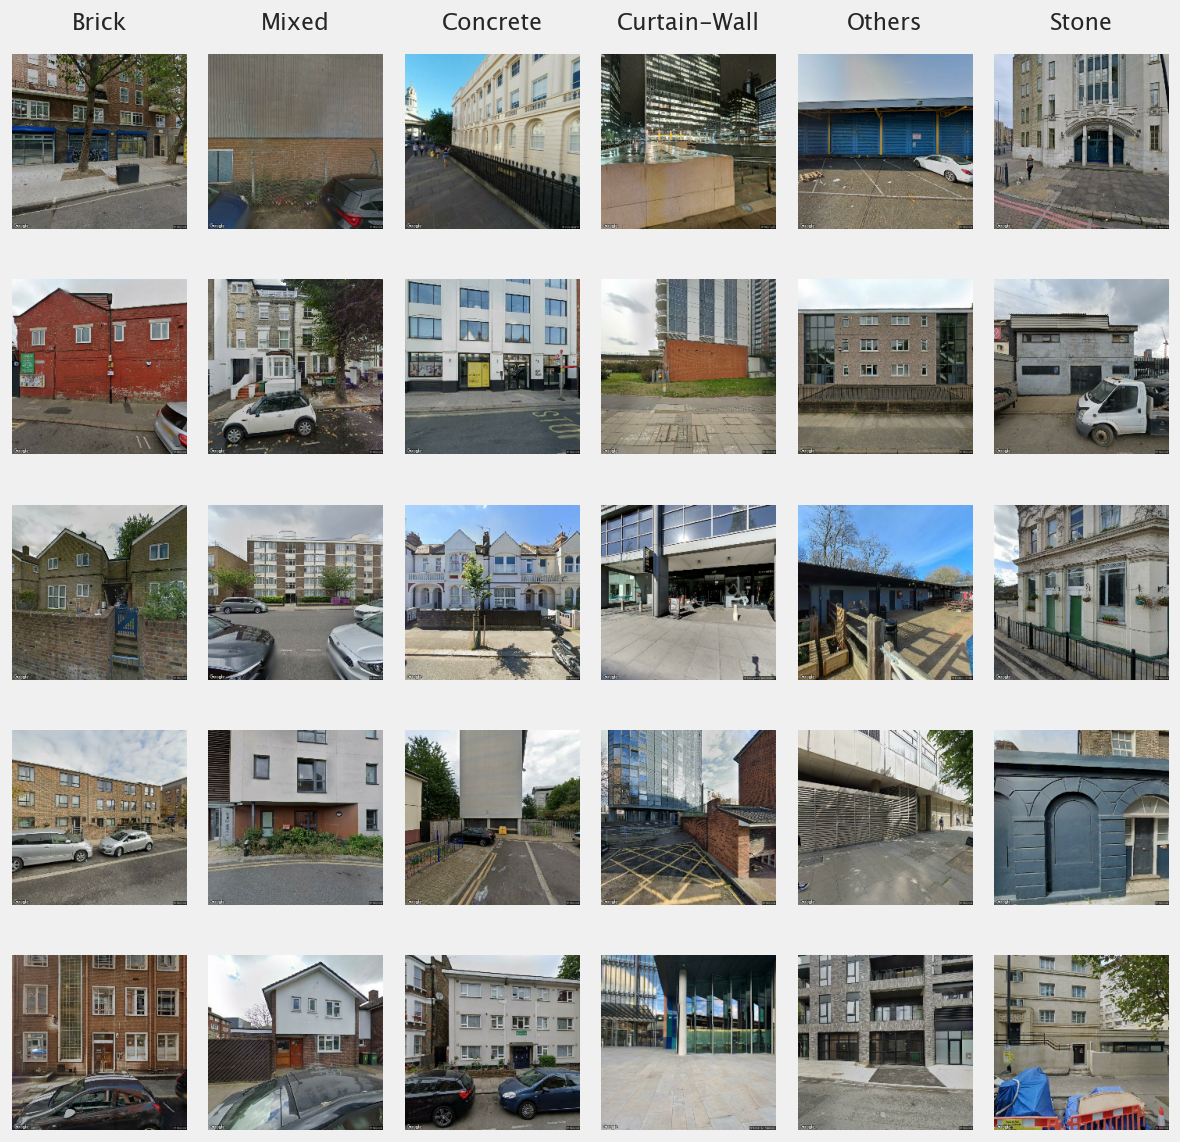

In [93]:
# visualize sample images of each class
plt.figure(figsize=(10, 10))
for class_idx, (class_name, imgs) in enumerate(class_images.items()):
    for img_idx, img in enumerate(imgs):
        ax = plt.subplot(5, len(class_names), img_idx * len(class_names) + class_idx + 1)
        plt.imshow(img.astype("uint8"))
        if img_idx == 0:
            plt.title(f"{class_name}", fontweight='bold')
        plt.axis("off")  
plt.tight_layout()
plt.show()

In [ ]:
# opt prefetching, determine the best buffer size depending the hardware
AUTOTUNE = tf.data.AUTOTUNE
train_ds_res = train_ds_res.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Model (ResNet50)

In [64]:
from tensorflow.keras import layers, models, applications

# load ResNet50 base model
base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze base model

# build top classifier
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### ResNet50 Training (London)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


# optional: save the best model
checkpoint_cb = ModelCheckpoint("resnet_cladding_model.h5", save_best_only=True)

# optional: stop if validation accuracy doesn't improve for 3 epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

if os.path.exists('resnet_cladding_model.h5'):
    model = load_model('resnet_cladding_model.h5')
    print("Loaded existing model -> resnet_cladding_model.h5")
else:
    print("No existing model found, starting training from scratch.")
    history = model.fit(
        train_ds_res,
        validation_data=val_ds,
        epochs=20,
        callbacks=[earlystop_cb, checkpoint_cb]
    )

Epoch 1/20


2025-04-12 20:52:04.528459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3254 - loss: 2.9827

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step - accuracy: 0.3265 - loss: 2.9872 - val_accuracy: 0.5714 - val_loss: 1.5447
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4535 - loss: 2.9001

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.4531 - loss: 2.9014 - val_accuracy: 0.5714 - val_loss: 1.3374
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5001 - loss: 2.3825

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.5001 - loss: 2.3842 - val_accuracy: 0.6266 - val_loss: 1.1830
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.5210 - loss: 2.1499 - val_accuracy: 0.6234 - val_loss: 1.3402
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.5925 - loss: 1.8632 - val_accuracy: 0.5877 - val_loss: 1.4760
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5996 - loss: 1.9147

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.5999 - loss: 1.9114 - val_accuracy: 0.6818 - val_loss: 1.1792
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.6424 - loss: 1.5543 - val_accuracy: 0.6656 - val_loss: 1.2851
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.5969 - loss: 1.7478 - val_accuracy: 0.6818 - val_loss: 1.2817
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.6722 - loss: 1.2282 - val_accuracy: 0.6461 - val_loss: 1.2787


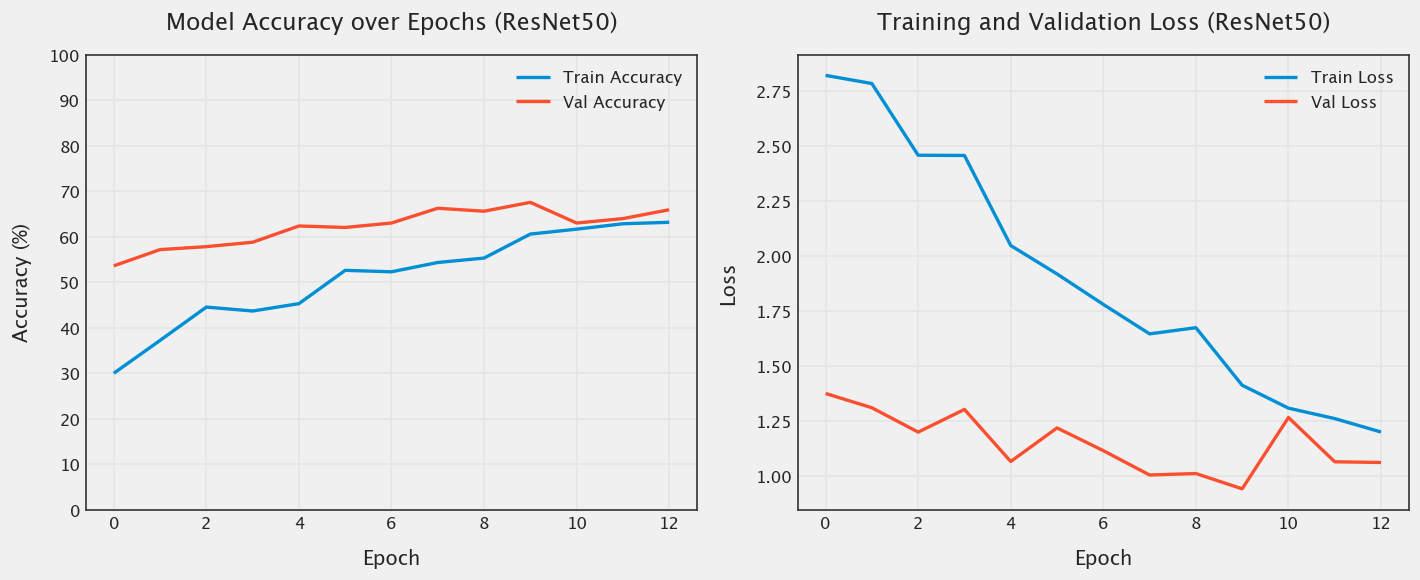

In [194]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, [a * 100 for a in acc], label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, [va * 100 for va in val_acc], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.yticks(range(0, 101, 10))
plt.ylim([0, 100]) 

plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### ResNet50 Test (London)

In [ ]:
test_ds_res = tf.keras.utils.image_dataset_from_directory(
    test_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_res = test_ds_res.prefetch(tf.data.AUTOTUNE)

NameError: name 'tf' is not defined

In [ ]:
loss, acc = model.evaluate(test_ds_res)
print(f"Test Accuracy: {acc:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.7221 - loss: 1.0035
Test Accuracy: 64.97%


2025-04-12 21:59:25.581599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step
              precision    recall  f1-score   support

       Brick       0.96      0.75      0.84        89
    Concrete       0.65      0.36      0.47        47
Curtain-Wall       0.70      0.47      0.56        15
       Mixed       0.55      0.92      0.69       120
      Others       0.57      0.12      0.20        34
       Stone       1.00      0.11      0.20         9

    accuracy                           0.66       314
   macro avg       0.74      0.45      0.49       314
weighted avg       0.70      0.66      0.62       314



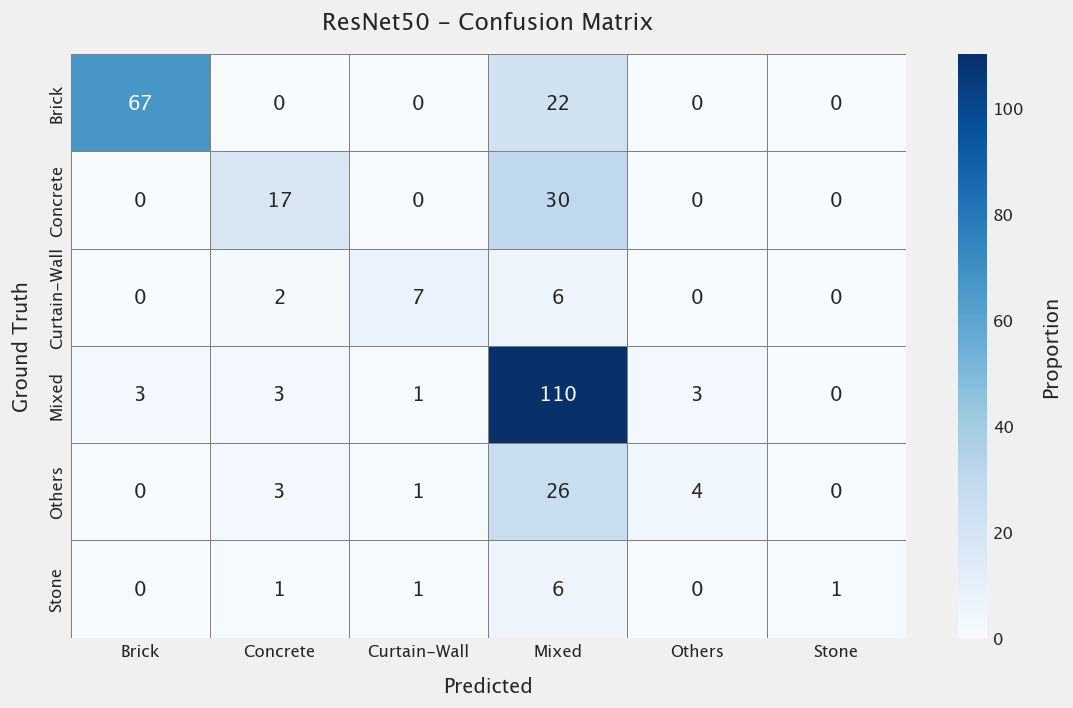

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = np.concatenate([y.numpy() for x, y in test_ds_res])
y_pred_probs = model.predict(test_ds_res)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

print(classification_report(y_true_labels, y_pred, target_names=class_names))

cm = confusion_matrix(y_true_labels, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proportion'})
plt.title("ResNet50 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

# Model (Inception V3)

Build transfer learning model (Inception V3)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

IMG_SIZE_INCEP = (299, 299)
BATCH_SIZE = 32

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # freeze convolutional base

inputs = Input(shape=(299, 299, 3))
x = preprocess_input(inputs)  # preprocess according to InceptionV3
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,830 (84.17 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
train_ds_incep = tf.keras.utils.image_dataset_from_directory(
    train_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds_incep = tf.keras.utils.image_dataset_from_directory(
    val_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 928 files belonging to 6 classes.
Found 308 files belonging to 6 classes.


### Inception V3 Training (London)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_cb_incep = ModelCheckpoint("inception_cladding_model.h5", save_best_only=True)

earlystop_cb_incep = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


if os.path.exists('inception_cladding_model.h5'):
    model = load_model('inception_cladding_model.h5')
    print("Loaded existing model -> inception_cladding_model.h5")
else:
    print("No existing model found, starting training from scratch.")
    history_inception = model.fit(
        train_ds_incep,
        validation_data=val_ds_incep,
        epochs=20,
        callbacks=[checkpoint_cb_incep]
    )

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6376 - loss: 1.1996

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.6377 - loss: 1.1991 - val_accuracy: 0.6429 - val_loss: 1.0279
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6430 - loss: 1.1887

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.6433 - loss: 1.1872 - val_accuracy: 0.6786 - val_loss: 0.9597
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.6563 - loss: 1.1410 - val_accuracy: 0.6721 - val_loss: 1.0050
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.6854 - loss: 1.0054 - val_accuracy: 0.6753 - val_loss: 1.0644
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.7044 - loss: 0.9139 - val_accuracy: 0.6753 - val_loss: 1.0510
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - accuracy: 0.6982 - loss: 0.8904 - val_accuracy: 0.6656 - val_loss: 0.9893
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7402 - loss: 0.8111 - val_accuracy: 0.6818 - val_loss: 1.0107
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7042 - loss: 0.8795 - val_accuracy: 0.6753 - val_loss: 1.0133
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.7768 - loss: 0.6752 - val_accuracy: 0.675

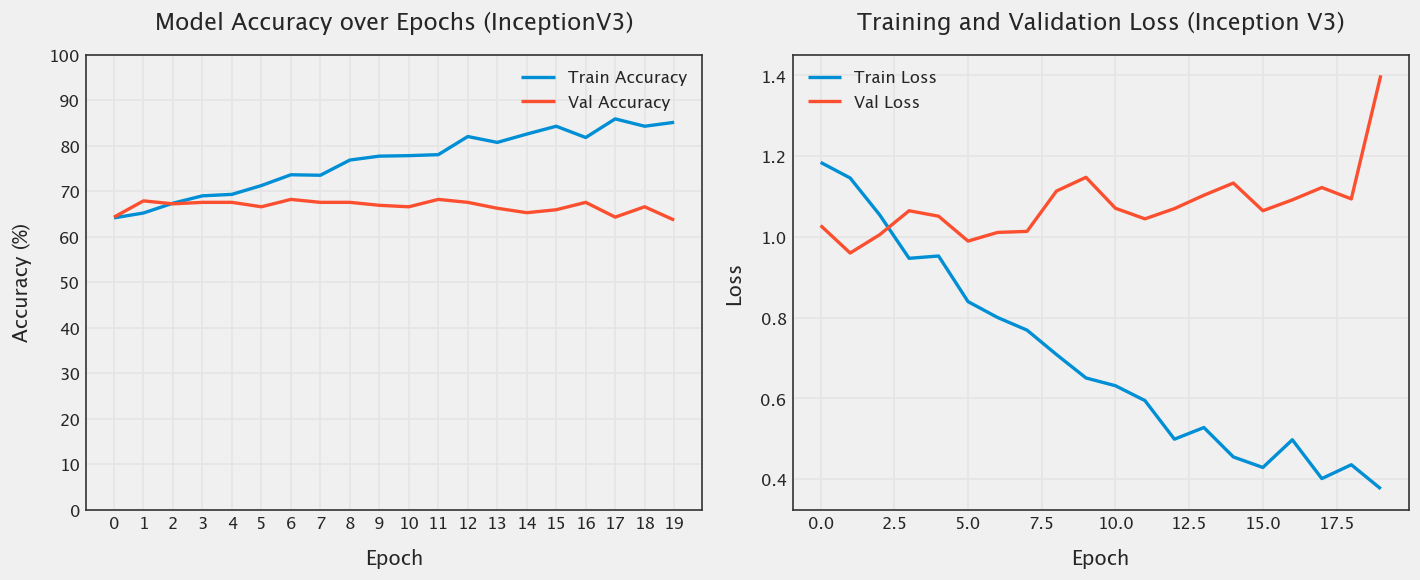

In [193]:
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, [a * 100 for a in acc], label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, [va * 100 for va in val_acc], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs (InceptionV3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.yticks(range(0, 101, 10))
plt.ylim([0, 100]) 
plt.xticks(epochs_range, [int(i) for i in epochs_range])  # Use integer ticks
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
plt.title('Training and Validation Loss (Inception V3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Inception V3 Test (London)

In [ ]:
test_ds_incep = tf.keras.utils.image_dataset_from_directory(
    test_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_incep = test_ds_incep.prefetch(tf.data.AUTOTUNE)

Found 314 files belonging to 6 classes.


In [ ]:
y_true = []
y_pred_probs = []

for x_batch, y_batch in test_ds_incep:
    preds = model.predict(x_batch, verbose=0)
    y_pred_probs.append(preds)
    y_true.append(y_batch.numpy())

y_true = np.concatenate(y_true)
y_pred_probs = np.concatenate(y_pred_probs)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)


2025-04-12 21:53:20.987429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision  recall  f1-score  support
Brick             85.87   88.76     87.29    89.00
Concrete          50.00   31.91     38.96    47.00
Curtain-Wall      60.00   60.00     60.00    15.00
Mixed             63.95   78.33     70.41   120.00
Others            42.86   35.29     38.71    34.00
Stone             50.00   11.11     18.18     9.00
accuracy          66.88   66.88     66.88     0.67
macro avg         58.78   50.90     52.26   314.00
weighted avg      65.20   66.88     65.06   314.00


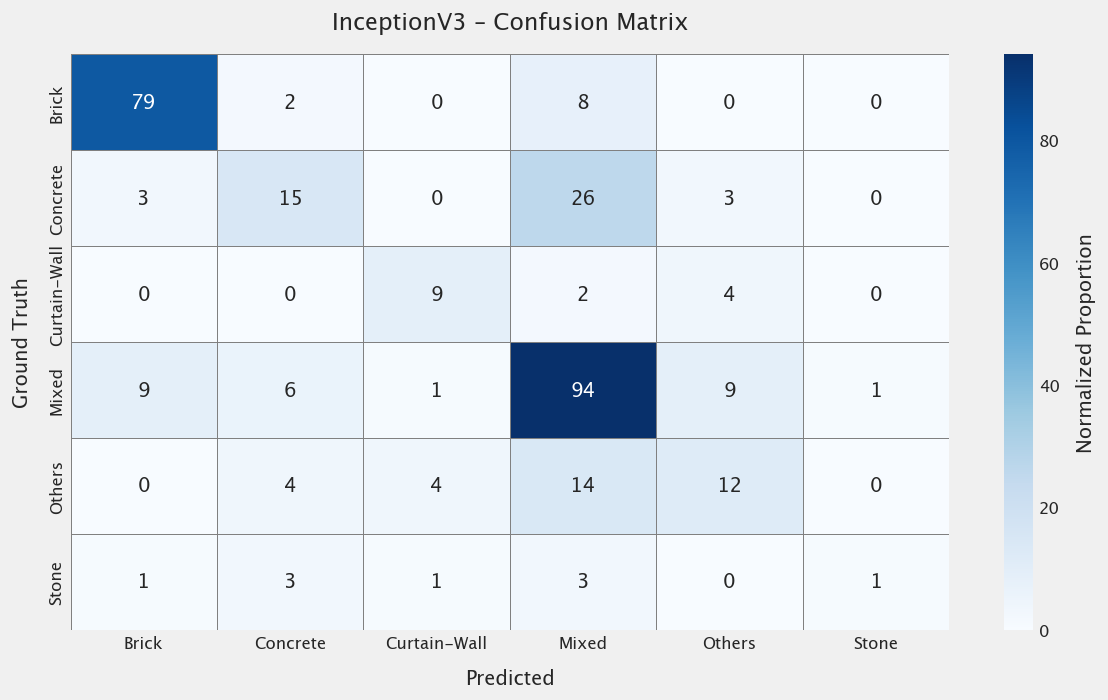

In [191]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).T
report_df[['precision', 'recall', 'f1-score']] *= 100
print(report_df[['precision', 'recall', 'f1-score', 'support']].round(2).to_string())

# confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=cm, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Normalized Proportion'}, linewidths=0.5, linecolor='gray')
plt.title("InceptionV3 – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()

## Run both models with the augmented dataset

In [196]:
base_path_london_aug = "/Users/meltemsahin/Documents/GitHub/applied-deep-learning/data/exterior_cladding_material/london/after_augmentation"
train_path_aug = os.path.join(base_path_london_aug, 'train')
val_path_aug = os.path.join(base_path_london_aug, 'val')
test_path_aug = os.path.join(base_path_london_aug, 'test')

In [198]:
# parameters
BATCH_SIZE = 32
IMG_SIZE_RES = (224, 224)

In [199]:
# for ResNet50 (224x224)
train_ds_res_aug = tf.keras.utils.image_dataset_from_directory(train_path_aug, image_size=IMG_SIZE_RES, batch_size=BATCH_SIZE, label_mode='categorical')
val_ds_res_aug = tf.keras.utils.image_dataset_from_directory(val_path_aug, image_size=IMG_SIZE_RES, batch_size=BATCH_SIZE, label_mode='categorical')
test_ds_res_aug = tf.keras.utils.image_dataset_from_directory(test_path_aug, image_size=IMG_SIZE_RES, batch_size=BATCH_SIZE, label_mode='categorical')

# for InceptionV3 (299x299)
train_ds_inc_aug = tf.keras.utils.image_dataset_from_directory(train_path_aug, image_size=IMG_SIZE_INCEP, batch_size=BATCH_SIZE, label_mode='categorical')
val_ds_inc_aug = tf.keras.utils.image_dataset_from_directory(val_path_aug, image_size=IMG_SIZE_INCEP, batch_size=BATCH_SIZE, label_mode='categorical')
test_ds_inc_aug = tf.keras.utils.image_dataset_from_directory(test_path_aug, image_size=IMG_SIZE_INCEP, batch_size=BATCH_SIZE, label_mode='categorical')


Found 6496 files belonging to 6 classes.
Found 308 files belonging to 6 classes.
Found 314 files belonging to 6 classes.
Found 6496 files belonging to 6 classes.
Found 308 files belonging to 6 classes.
Found 314 files belonging to 6 classes.


# Train the Augmented Comparision Model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_res_aug = train_ds_res_aug.prefetch(AUTOTUNE)
val_ds_res_aug = val_ds_res_aug.prefetch(AUTOTUNE)
test_ds_res_aug = test_ds_res_aug.prefetch(AUTOTUNE)

train_ds_inc_aug = train_ds_inc_aug.prefetch(AUTOTUNE)
val_ds_inc_aug = val_ds_inc_aug.prefetch(AUTOTUNE)
test_ds_inc_aug = test_ds_inc_aug.prefetch(AUTOTUNE)

# Setup for Scotland

Paths

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [1]:
base_path_scot = '/Users/meltemsahin/Documents/GitHub/applied-deep-learning/data/exterior_cladding_material/scotland/before_augmentation'
train_path_scot = os.path.join()

NameError: name 'os' is not defined